In [3]:
%matplotlib inline

In [4]:
import os, sys, threading

import numpy as np
import tensorflow as tf

import keras
from keras.utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers.core import RepeatVector, Permute
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.initializers import TruncatedNormal
from keras.optimizers import RMSprop, Adam

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

import matplotlib.pyplot as plt
from keras import backend as K

Using TensorFlow backend.


In [6]:
def y_true_min(yt, yp):
    return K.min(yt)
def y_true_max(yt, yp):
    return K.max(yt)
def y_pred_min(yt, yp):
    return K.min(yp)
def y_pred_max(yt, yp):
    return K.max(yp)

In [7]:
# Helper function

def batch_apply(ndarray, func, *args, **kwargs):
    batch = []
    for sample in ndarray:
        batch.append(func(sample, *args, **kwargs))
    return np.array(batch)

In [ ]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
def create_inception_embedding(grayscaled_rgb):
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb)
    return embed

In [ ]:
with tf.device('/cpu:0'):
    #Inputs
    embed_input = Input(shape=(1000,))
    encoder_input = Input(shape=(256, 256, 1,))
    
    #Encoder
    encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_input)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    batch, height, width, channels = K.int_shape(encoder_output)
    #Fusion
#     fusion_output = RepeatVector(height * width)(embed_input) 
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
#     fusion_output = Reshape(([height, width, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(fusion_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(32, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = Conv2D(16, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    
    model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [ ]:
datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=20, horizontal_flip=True)

In [ ]:
def process_images(rgb, input_size=(256, 256, 3), embed_size=(299, 299, 3)):
    # Resize for embed and Convert to grayscale
    gray = gray2rgb(rgb2gray(rgb))
    gray = batch_apply(gray, resize, embed_size, mode='constant')
    # Zero-Center [-1, 1]
    gray = gray * 2 - 1
    # Generate embeddings
    embed = create_inception_embedding(gray)
    
    # Resize to input size of model
    re_batch = batch_apply(rgb, resize, input_size, mode='constant')
    # RGB => L*a*b*
    re_batch = batch_apply(re_batch, rgb2lab)
    
    # Extract L* into X, zero-center and normalize
    X_batch = re_batch[:,:,:,0]
    X_batch = X_batch/50 - 1
    X_batch = X_batch.reshape(X_batch.shape+(1,))
    
    # Extract a*b* into Y and normalize. Already zero-centered.
    Y_batch = re_batch[:,:,:,1:]
    Y_batch = Y_batch/128
    
    return [X_batch, embed], Y_batch

In [ ]:
def image_a_b_gen(images, batch_size):
    while True:
        for batch in datagen.flow(images, batch_size=batch_size):
            yield process_images(batch)

In [ ]:
DATASET = './imagenet_12k_new/'

training_files, testing_files = train_test_split(shuffle(os.listdir(DATASET)), test_size=0.1)
# training_files = ['image_0.jpg']
# testing_files = ['image_0.jpg']

def getImages(DATASET, filelist, transform_size=(299, 299, 3)):
    """Reads JPEG filelist from DATASET and returns float represtation of RGB [0.0, 1.0]"""
    img_list = []
    for i,filename in enumerate(filelist):
        if i < 3000: 
            if 'jpg' or 'jpeg' or 'JPEG' in filename:
#                 image_in = batch_apply(img_to_array, load_img(DATASET + filename))
                image_in = img_to_array(load_img(DATASET + filename))
#                 image_in = img_to_array(load_img(filename))

                image_in = image_in/255

                if transform_size is not None:
#                     image_in = batch_apply(image_in, resize, transform_size, mode='reflect')
                    image_in = resize(image_in, transform_size, mode='reflect')

                img_list.append(image_in)
    img_list = np.array(img_list)
    
    return img_list

In [ ]:
len(training_files)

In [ ]:
# model.compile(optimizer=RMSprop(lr=1e-3), loss='mse')
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=[y_true_max, y_true_min, y_pred_max, y_pred_min])

In [14]:
model.load_weights(filepath='model_output/colorize_imagenet_2000.hdf5', by_name=True)

In [18]:
def train(model, training_files, batch_size=125, epochs=30, steps_per_epoch=80):
    training_set = getImages(DATASET, training_files)
    train_size = int(len(training_set)*0.85)
#     train_size = int(len(training_set)*1)
    train_images = training_set[:train_size]
    val_images = training_set[train_size:]
    val_steps = (len(val_images)//batch_size)
    print("Training samples:", train_size, "Validation samples:", len(val_images))

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1e-5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=0, verbose=1, min_lr=1e-8),
        ModelCheckpoint(monitor='val_loss', filepath='model_output/colorize_imagenet_10000.hdf5', verbose=1,
                         save_best_only=True, save_weights_only=True, mode='auto'),
        TensorBoard(log_dir='./logs', histogram_freq=10, batch_size=20, write_graph=True, write_grads=True,
                    write_images=False, embeddings_freq=0)
    ]

#     model.fit_generator(image_a_b_gen(train_images, batch_size), epochs=epochs, steps_per_epoch=steps_per_epoch,
#                         verbose=1)
    
    model.fit_generator(image_a_b_gen(train_images, batch_size), epochs=epochs, steps_per_epoch=steps_per_epoch,
                        verbose=1, callbacks=callbacks, validation_data=process_images(val_images))

In [2]:
def test(model, testing_files, save_actual=False, save_gray=False):
    test_images = getImages(DATASET, testing_files)
    model.load_weights(filepath='model_output/colorize_imagenet_10000.hdf5', by_name=True)

    print('Preprocessing Images')
    X_test, Y_test = process_images(test_images)
    
    print('Predicting')
    # Test model
    output = model.predict(X_test)
    
    # Rescale a*b* back. [-1.0, 1.0] => [-128.0, 128.0]
    output = output * 128
    Y_test = Y_test * 128

    # Output colorizations
    for i in range(len(output)):
        name = testing_files[i].split(".")[0]
        print('Saving '+str(i)+"th image " + name + "_*.png")
        
        lightness = X_test[0][i][:,:,0]
        
        #Rescale L* back. [-1.0, 1.0] => [0.0, 100.0]
        lightness = (lightness + 1) * 50
        
        predicted = np.zeros((256, 256, 3))
        predicted[:,:,0] = lightness
        predicted[:,:,1:] = output[i]
        plt.imsave("result/predicted_10000/" + name + ".jpeg", lab2rgb(predicted))
        
        if save_gray:
            bnw = np.zeros((256, 256, 3))
            bnw[:,:,0] = lightness
            plt.imsave("result/bnw_10000/" + name + ".jpeg", lab2rgb(bnw))
        
        if save_actual:
            actual = np.zeros((256, 256, 3))
            actual[:,:,0] = lightness
            actual[:,:,1:] = Y_test[i]
            plt.imsave("result/actual_10000/" + name + ".jpeg", lab2rgb(actual))

In [ ]:
train(model, training_files, epochs=100)

Training samples: 2550 Validation samples: 450
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
80/80 [==============================] - 12870s 161s/step - loss: 0.0146 - y_true_max: 0.7281 - y_true_min: -0.7547 - y_pred_max: 0.3458 - y_pred_min: -0.2919 - val_loss: 0.0152 - val_y_true_max: 0.7295 - val_y_true_min: -0.7605 - val_y_pred_max: 0.4255 - val_y_pred_min: -0.3388

Epoch 00001: val_loss improved from inf to 0.01525, saving model to model_output/colorize_imagenet_10000.hdf5
Epoch 2/100
80/80 [==============================] - 12318s 154s/step - loss: 0.0133 - y_true_max: 0.7278 - y_true_min: -0.7577 - y_pred_max: 0.4111 - y_pred_min: -0.3800 - val_loss: 0.0156 - val_y_true_max: 0.7295 - val_y_true_min: -0.7605 - val_y_pred_max: 0.4342 - val_y_pred_min: -0.4973

Epoch 00002: val_loss did not improve from 0.01525
Epoch 3/100
50/80 [=================>............] - ETA: 1:18:17 - loss: 0.0127 - y_true_max: 0.7221 - y_true_min: -0.7498 - y_pred_max: 0.4421 - y_pred_min:

In [1]:
s

NameError: name 's' is not defined

In [ ]:
test(model, testing_files, True, True)

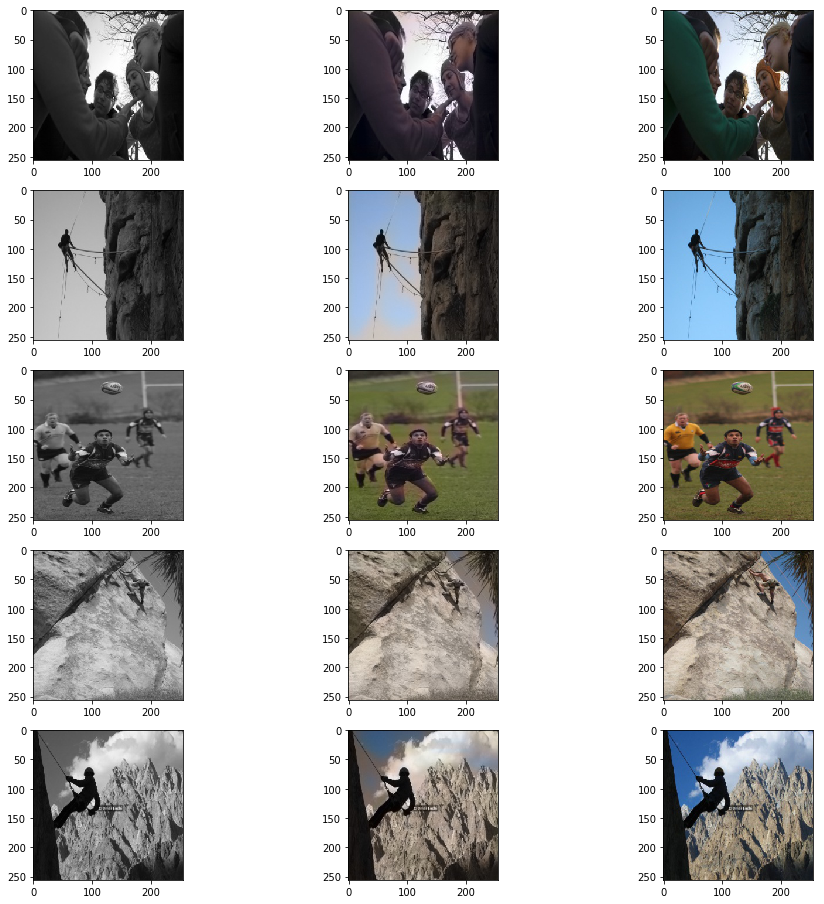

In [20]:
filelist = shuffle(os.listdir('result/predicted_10000/'))
filelist = filelist[:5]

fig, ax = plt.subplots(5, 3, figsize=(16,16))
row = 0
for filename in filelist:
    folder = 'result/bnw_2000/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,0].imshow(image_in)
    
    folder = 'result/predicted_2000/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,1].imshow(image_in)
    
    folder = 'result/actual_2000/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,2].imshow(image_in)
    
    row += 1